# Initialization and data prep

In [11]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

datadir = './raw_data/'
resdir = './results/'

In [12]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = table[0]['Symbol'].to_list()
sp500_list = [s.replace('.', '-') for s in sp500_list]
len(sp500_list)

503

In [13]:
table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')
nasdaq_list = table[4]['Ticker'].to_list()
nasdaq_list = [s.replace('.', '-') for s in nasdaq_list]
len(nasdaq_list)

102

In [14]:
table = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
dj_list = table[1]['Symbol'].to_list()
dj_list = [s.replace('.', '-') for s in dj_list]
len(dj_list)

30

In [15]:
stock_pool = list(set(sp500_list).union(set(nasdaq_list)).union(set(dj_list))) + ['OKTA']
print(len(stock_pool))
year = '2022'
# start, end = year+'-01-01', year+'-12-31'
start, end = year+'-01-01', year+'-10-31'

526


### Downloading from yfinance, no need if there is source files

In [231]:
# from main import stocks_norm_return
# norm_return = stocks_norm_return(stock_pool, start, end, dropna=True)
# norm_return.to_csv(datadir+f'all_stocks_return_{start}_{end}.csv', index=True)

In [232]:
# spy = yf.download("SPY", start=start, end=end)
# spy.to_csv(datadir+f'spy_{start}_{end}.csv', index=True)

In [233]:
norm_return = pd.read_csv(datadir+f'all_stocks_return_{start}_{end}.csv', index_col=0)
norm_return.index = pd.to_datetime(norm_return.index)
spy = pd.read_csv(datadir+f'spy_{start}_{end}.csv', index_col=0)
spy.index = pd.to_datetime(spy.index)

# MC Simulation part

In [234]:
from main import MC_portfolio

p = MC_portfolio(norm_return, 1e6)
p.mc_stock_choice(iter=20000, k=100, history=True)
p.best_sharpe, p.best_pnl, p.best_stocks

(-0.5567487002134708,
 0.9728278105510013,
 array(['DUK', 'EQT', 'LHX', 'AXP', 'MELI', 'MTD', 'AEP', 'SIRI', 'XEL',
        'CB', 'MLM', 'AMGN', 'ALK', 'MDT', 'WAB', 'ENPH', 'AMCR', 'MPC',
        'ALL', 'SRE', 'SEDG', 'PPL', 'KR', 'MA', 'ICE', 'FTNT', 'WMB',
        'DGX', 'TEL', 'MSI', 'ADI', 'MAR', 'SNA', 'APA', 'KDP', 'ROL',
        'SEE', 'VRSN', 'AWK', 'NRG', 'SLB', 'PDD', 'CVS', 'RTX', 'UDR',
        'BF-B', 'AAL', 'FISV', 'MSFT', 'LW', 'ADBE', 'GPC', 'OXY', 'CTRA',
        'BDX', 'AVGO', 'NTES', 'ELV', 'AME', 'HWM', 'BXP', 'MMM', 'SO',
        'CRM', 'FTV', 'CMI', 'ATO', 'TDY', 'WRB', 'CPB', 'NTRS', 'V',
        'GIS', 'DXC', 'WMT', 'COST', 'BWA', 'PSA', 'JPM', 'COF', 'MTB',
        'DIS', 'NI', 'WHR', 'AZN', 'ECL', 'WEC', 'SBUX', 'DOCU', 'VRSK',
        'AFL', 'YUM', 'KEY', 'BKNG', 'ALLE', 'ED', 'EW', 'BBWI', 'CPRT',
        'LVS'], dtype=object))

In [235]:
hist = {}
for idx in np.argpartition(p.history_sharpe, -100)[-100:]:
    for s in p.history_stocks[idx]:
        if hist.get(s, -1) == -1:
            hist[s] = 1
        else:
            hist[s] += 1
hist_df = pd.DataFrame(hist.items(), columns=['stock', 'freq']).sort_values('freq')

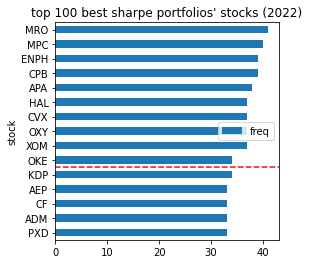

In [236]:
topk, bestk = 15, 10
ax = hist_df.tail(topk).plot.barh(x='stock', figsize=(4,4), title=f"top 100 best sharpe portfolios' stocks ({year})")
ax.axhline(topk-bestk-0.5, c='red', ls='--')
plt.savefig(resdir+f"sharpe{year}.png")

In [237]:
my_best_stocks1 = hist_df.tail(bestk).stock.values
f_weights1 = (hist_df.tail(bestk).freq / hist_df.tail(bestk).freq.sum()).values
p.mc_weight_choice(my_best_stocks1, iter=5000, by='sharpe')
mc_weights1 = p.best_weights

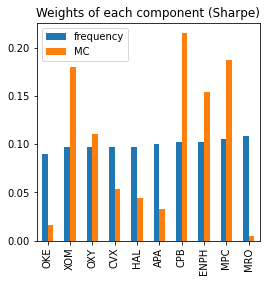

In [238]:
fig, ax = plt.subplots(figsize=(4,4))
dfw = pd.DataFrame({'frequency': f_weights1, 'MC': mc_weights1}, index=my_best_stocks1)
dfw.plot.bar(ax=ax)
plt.title('Weights of each component (Sharpe)')
plt.savefig(resdir+f"sharpeweight{year}.png")
dfw.to_csv(resdir+f'sharpe{year}.csv')

In [239]:
hist = {}
for idx in np.argpartition(p.history_pnl, -100)[-100:]:
    for s in p.history_stocks[idx]:
        if hist.get(s, -1) == -1:
            hist[s] = 1
        else:
            hist[s] += 1
hist_df = pd.DataFrame(hist.items(), columns=['stock', 'freq']).sort_values('freq')

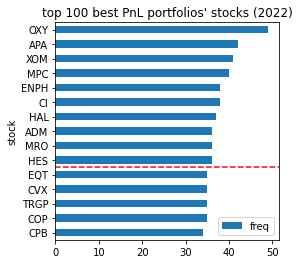

In [240]:
ax = hist_df.tail(topk).plot.barh(x='stock', figsize=(4,4), title=f"top 100 best PnL portfolios' stocks ({year})")
ax.axhline(topk-bestk-0.5, c='red', ls='--')
plt.savefig(resdir+f"pnl{year}.png")

In [241]:
my_best_stocks2 = hist_df.tail(bestk).stock.values
f_weights2 = (hist_df.tail(bestk).freq / hist_df.tail(bestk).freq.sum()).values
p.mc_weight_choice(my_best_stocks2, iter=5000, by='pnl')
mc_weights2 = p.best_weights

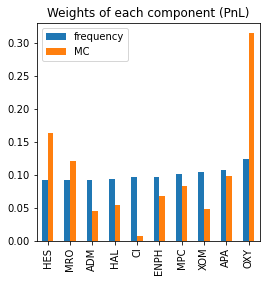

In [242]:
fig, ax = plt.subplots(figsize=(4,4))
dfw = pd.DataFrame({'frequency': f_weights2, 'MC': mc_weights2}, index=my_best_stocks2)
dfw.plot.bar(ax=ax)
plt.title('Weights of each component (PnL)')
plt.savefig(resdir+f"pnlweight{year}.png")
dfw.to_csv(resdir+f'pnl{year}.csv')

Text(0, 0.5, 'Percentage Position')

<Figure size 1152x576 with 0 Axes>

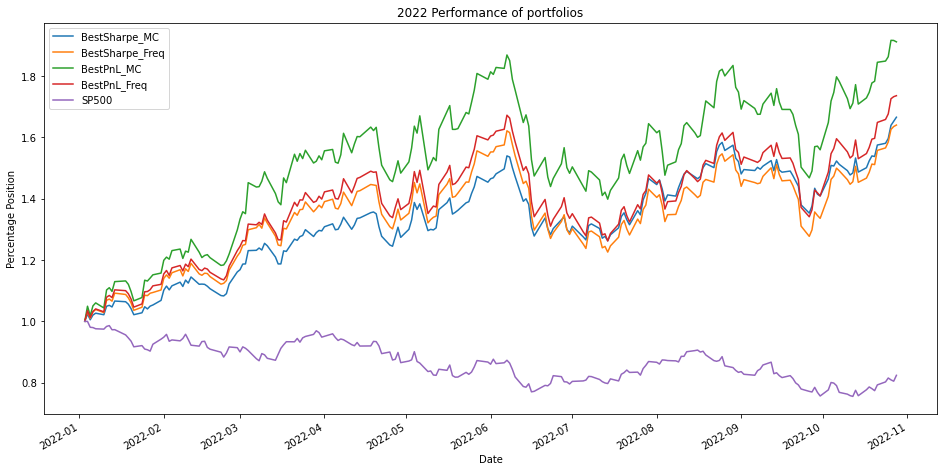

In [243]:
from main import build_portfolio, init_weight_choice
fig = plt.figure(figsize=(16,8))

bsharpe_mc = build_portfolio(norm_return, 1e6, my_best_stocks1 , mc_weights1)
bsharpe_f = build_portfolio(norm_return, 1e6, my_best_stocks1 , f_weights1)

bpnl_mc = build_portfolio(norm_return, 1e6, my_best_stocks2 , mc_weights2)
bpnl_f = build_portfolio(norm_return, 1e6, my_best_stocks2 , f_weights2)

spy_PerPos = spy['Adj Close'] / spy['Adj Close'].iloc[0]

super_df = pd.concat([bsharpe_mc.PercentagePos, bsharpe_f.PercentagePos, bpnl_mc.PercentagePos, bpnl_f.PercentagePos, spy_PerPos], axis=1)
super_df.columns = ['BestSharpe_MC', 'BestSharpe_Freq', 'BestPnL_MC', 'BestPnL_Freq', 'SP500']
super_df.plot(figsize=(16,8))
plt.title('2022 Performance of portfolios')
plt.ylabel('Percentage Position')

In [244]:
bsharpe_f.DailyPercentageReturn.min(), bsharpe_mc.DailyPercentageReturn.min(), bpnl_f.DailyPercentageReturn.min(), bpnl_mc.DailyPercentageReturn.min()

(-0.08775394833709904,
 -0.06322208693552511,
 -0.09456586759886287,
 -0.10550144956023311)

In [245]:
bsharpe_f.DailyPercentageReturn.std(), bsharpe_mc.DailyPercentageReturn.std(), bpnl_f.DailyPercentageReturn.std(), bpnl_mc.DailyPercentageReturn.std()

(0.023084363334032975,
 0.019185208872773123,
 0.023728505032628015,
 0.027740435192048607)

In [2]:
from main import sharpe
def port_sharpe(norm_return_tmp, weights, tdays=252): 
    log_return = np.log(norm_return_tmp/norm_return_tmp.shift(1))
    exp_return = np.sum(log_return.mean() * weights) * tdays
    exp_volatility = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * tdays, weights)))
    sp = sharpe(exp_return, exp_volatility, risk_free_ret=0)
    return sp

# Final test part

In [3]:
df18 = pd.read_csv(resdir+'sharpe2018.csv', index_col=0)
df19 = pd.read_csv(resdir+'sharpe2019.csv', index_col=0)
df20 = pd.read_csv(resdir+'sharpe2020.csv', index_col=0)
df21 = pd.read_csv(resdir+'sharpe2021.csv', index_col=0)
df22 = pd.read_csv(resdir+'sharpe2022.csv', index_col=0)

### Downloading from yfinance, no need if there is source files

In [17]:
from main import stocks_norm_return
# norm_return = stocks_norm_return(stock_pool, '2018-01-01', '2022-11-30', dropna=False)
# spy = yf.download("SPY", start='2018-01-01', end='2022-11-30')
# norm_return.to_csv(datadir+'all_return.csv')
# spy.to_csv(datadir+'all_spy.csv')

# norm_return = stocks_norm_return(stock_pool, '2022-11-01', '2022-11-30', dropna=False)
# spy = yf.download("SPY", start='2022-11-01', end='2022-11-30')
# norm_return.to_csv(datadir+'nov22_return.csv')
# spy.to_csv(datadir+'nov22_spy.csv')

norm_return = pd.read_csv(datadir+'all_return.csv', index_col=0)
spy = pd.read_csv(datadir+'all_spy.csv', index_col=0)

In [18]:
from main import build_portfolio
p18 = build_portfolio(norm_return, 1e6, df18.index.to_list() , df18['MC'].values)
p19 = build_portfolio(norm_return, 1e6, df19.index.to_list() , df19['MC'].values)
p20 = build_portfolio(norm_return, 1e6, df20.index.to_list() , df20['MC'].values)
p21 = build_portfolio(norm_return, 1e6, df21.index.to_list() , df21['MC'].values)
p22 = build_portfolio(norm_return, 1e6, df22.index.to_list() , df22['MC'].values)
spy_PerPos = spy['Adj Close'] / spy['Adj Close'].iloc[0]

In [29]:
def component_final_performance(p, df):
    return (p[df.index.to_list()] / p[df.index.to_list()].iloc[0]).iloc[-1].to_dict()
print(component_final_performance(p18, df18))
print(component_final_performance(p19, df19))
print(component_final_performance(p20, df20))
print(component_final_performance(p21, df21))
print(component_final_performance(p22, df22))

{'IPG': 2.0529353490827718, 'ENPH': 116.68847145258358, 'AAP': 1.467731263385648, 'ZBRA': 2.572751033455237, 'MSCI': 3.9992074731417966, 'OKTA': 1.9368859324743777, 'MSI': 3.144748633670574, 'TEAM': 2.5926476535437897, 'ETSY': 5.85117607776415, 'DXCM': 7.614416016176052}
{'T': 0.9864243268082504, 'MTCH': 1.5211883461775122, 'TSN': 0.9156325478128078, 'EQIX': 1.6450821578916928, 'AZN': 2.172523908770048, 'NVR': 1.2913380750726122, 'HSY': 2.29384576661315, 'CPRT': 2.9559635181939194, 'SEDG': 7.643889932597656, 'ENPH': 116.68847145258358}
{'ENPH': 116.68847145258357, 'PDD': 2.9374531110141167, 'NVDA': 3.1691707024679667, 'DOCU': 1.1215706490487118, 'CRWD': 2.3793103448275863, 'ETSY': 5.851176077764152, 'ZS': 4.086363821318655, 'MRNA': 9.309139265877931, 'ZM': 1.1382258015294227, 'TSLA': 8.46239013093957}
{'FDS': 2.4619802638595254, 'IPG': 2.0529353490827718, 'MAA': 1.905020323307683, 'LLY': 4.729185273394859, 'DGX': 1.6671974440737485, 'WST': 2.2878405069853325, 'EXR': 2.0954913896272305,

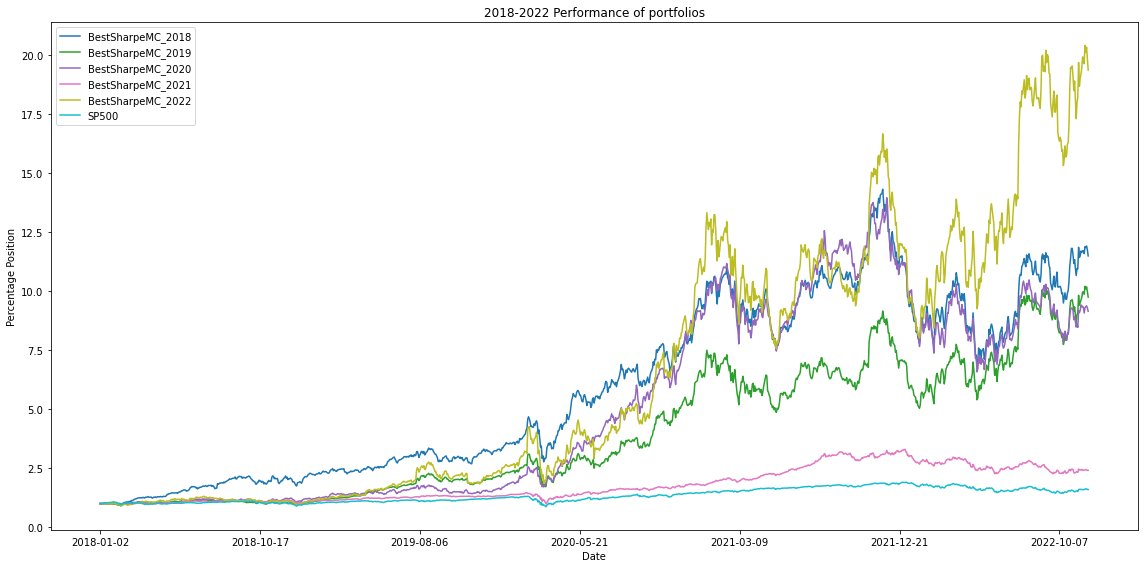

In [22]:
super_df = pd.concat([p18.PercentagePos, p19.PercentagePos, p20.PercentagePos, p21.PercentagePos, p22.PercentagePos, spy_PerPos], axis=1)
super_df.columns = ['BestSharpeMC_2018', 'BestSharpeMC_2019', 'BestSharpeMC_2020', 'BestSharpeMC_2021', 'BestSharpeMC_2022', 'SP500']
super_df.plot(figsize=(16,8), colormap='tab10')
plt.title('2018-2022 Performance of portfolios')
plt.ylabel('Percentage Position')
plt.tight_layout()
plt.savefig(resdir+'2018-2022.png')

In [59]:
print(port_sharpe(p18[df18.index.to_list()], df18['MC'].values, tdays=252*5-23))
print(port_sharpe(p19[df19.index.to_list()], df19['MC'].values, tdays=252*5-23))
print(port_sharpe(p20[df20.index.to_list()], df20['MC'].values, tdays=252*5-23))
print(port_sharpe(p21[df21.index.to_list()], df21['MC'].values, tdays=252*5-23))
print(port_sharpe(p22[df22.index.to_list()], df22['MC'].values, tdays=252*5-23))

1.914486816374584
1.815860075081037
1.703238953186892
1.720399546336932
1.4633710144690448


In [66]:
sharpe(spy_PerPos.diff().mean(), spy_PerPos.diff().std(), kval=np.sqrt(252*5-23), risk_free_ret=0)

0.97240760935945